Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import hdbscan

import joblib
import json

Load Data and Drop Non-informative Columns

In [2]:
df = pd.read_csv("Bank_Transaction_Fraud_Detection.csv")
drop_cols = [
    'Customer_ID', 'Customer_Name', 'Transaction_ID', 'Merchant_ID',
    'Customer_Contact', 'Customer_Email', 'Transaction_Date', 'Transaction_Time',
    'Transaction_Location', 'Transaction_Description'
]
df.drop(columns=drop_cols, inplace=True)

#label y di simpan untuk membantu evaluasi
y_label = df['Is_Fraud']
df.drop(columns=['Is_Fraud'], inplace=True)

Exploratory Data Analysis (EDA)

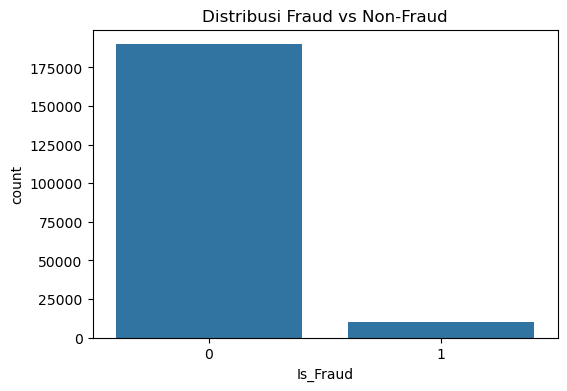

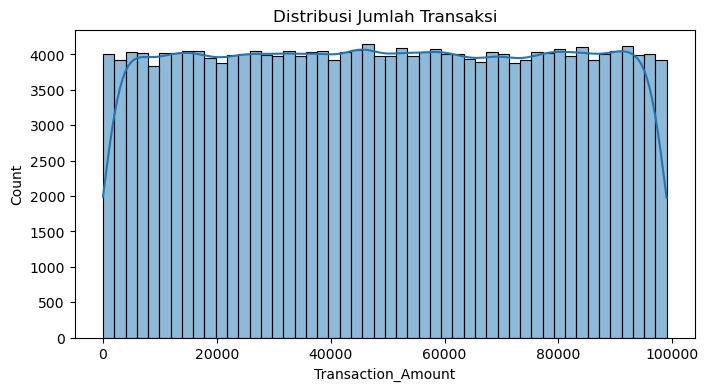

In [3]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_label)
plt.title("Distribusi Fraud vs Non-Fraud")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['Transaction_Amount'], bins=50, kde=True)
plt.title("Distribusi Jumlah Transaksi")
plt.show()

Preprocessing & Feature Engineering

In [4]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
cat_cols = ['Account_Type', 'Transaction_Type', 'Merchant_Category', 'Device_Type']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = ohe.fit_transform(df[cat_cols])
encoded_cols = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=df.index)

X_numeric = df.drop(columns=cat_cols + ['State', 'City', 'Bank_Branch', 'Transaction_Device', 'Transaction_Currency'])
X_full = pd.concat([X_numeric, encoded_cols], axis=1)

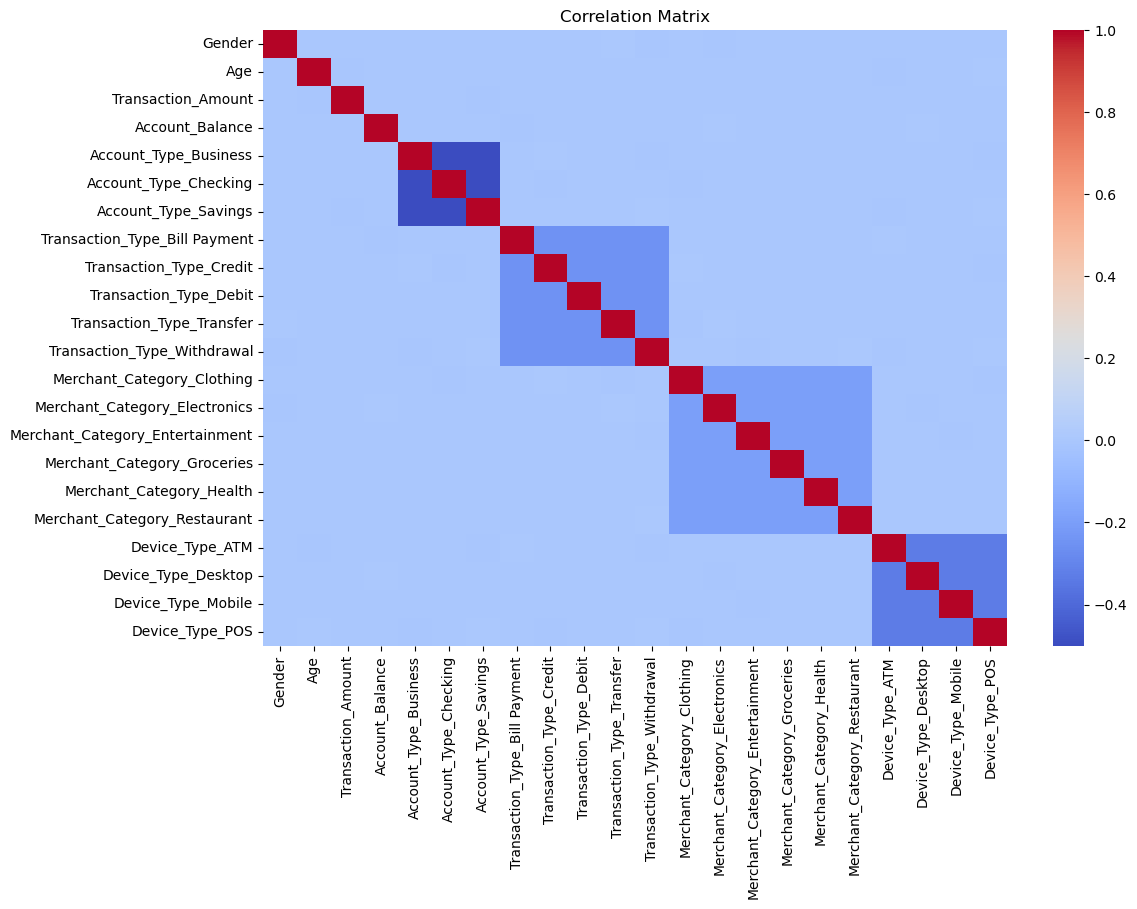

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_full.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

Feature Selection with XGBoost


Fitur yang dipilih (importance >= 2%):
Device_Type_Mobile                 5.34
Account_Type_Checking              5.21
Transaction_Type_Withdrawal        4.92
Merchant_Category_Entertainment    4.88
Gender                             4.87
Merchant_Category_Clothing         4.69
Account_Type_Business              4.66
Merchant_Category_Electronics      4.61
Device_Type_POS                    4.57
Age                                4.56
Transaction_Amount                 4.56
Device_Type_Desktop                4.55
Merchant_Category_Groceries        4.49
Transaction_Type_Credit            4.48
Device_Type_ATM                    4.39
Merchant_Category_Health           4.35
Account_Balance                    4.31
Account_Type_Savings               4.29
Merchant_Category_Restaurant       4.13
Transaction_Type_Transfer          4.12
Transaction_Type_Bill Payment      4.03
Transaction_Type_Debit             3.99
dtype: float32


C:\Users\Laptop Sandy\AppData\Local\Temp\ipykernel_16048\4063824329.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=important_features.values, y=important_features.index, palette='cubehelix')


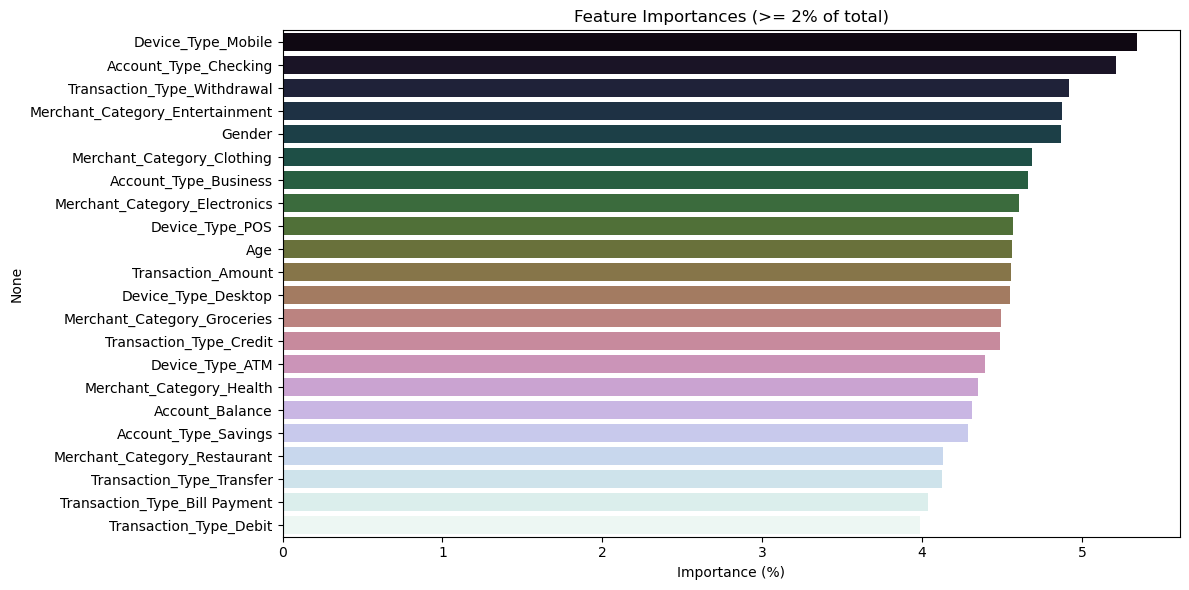

In [6]:
xgb_temp = XGBClassifier(n_estimators=100, random_state=42)
xgb_temp.fit(X_full, y_label)
feature_importances = pd.Series(xgb_temp.feature_importances_, index=X_full.columns)
sorted_importance = feature_importances.sort_values(ascending=False)

# Alasan: Threshold >= 2% dipilih untuk menyaring fitur yang benar-benar berpengaruh
feature_importance_percent = 100 * sorted_importance / sorted_importance.sum()
important_features = feature_importance_percent[feature_importance_percent >= 2.0]

print("\nFitur yang dipilih (importance >= 2%):")
print(important_features.round(2))

plt.figure(figsize=(12, 6))
sns.barplot(x=important_features.values, y=important_features.index, palette='cubehelix')
plt.title("Feature Importances (>= 2% of total)")
plt.xlabel("Importance (%)")
plt.tight_layout()
plt.show()

Feature Scaling

In [7]:
X_selected = X_full[important_features.index]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [ ]:
model = XGBClassifier()
model.load_model("fraud_detection_model_pseudolabel.json") 
scaler = joblib.load("scaler.pkl")
encoder = joblib.load("encoder.pkl")

with open("selected_features.json") as f:
    selected_features = json.load(f)

: 

Clustering Comparison (Unsupervised Models)

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_pred = kmeans.fit_predict(X_scaled)

dbscan = DBSCAN(eps=2, min_samples=10)
dbscan_pred = dbscan.fit_predict(X_scaled)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm_pred = gmm.fit_predict(X_scaled)

print("Silhouette Scores:")
print("KMeans:", silhouette_score(X_scaled, kmeans_pred))
print("DBSCAN:", silhouette_score(X_scaled, dbscan_pred[dbscan_pred != -1]) if len(set(dbscan_pred)) > 1 else "N/A")
print("GMM:", silhouette_score(X_scaled, gmm_pred))

c:\Users\Laptop Sandy\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

HDBSCAN - Best Performing Clustering

In [ ]:
# Catatan: min_cluster_size merupakan hasil tuning namun tidak ditampilkan karena waktu training sangat lama (> 4 jam)
hdb = hdbscan.HDBSCAN(min_cluster_size=100, prediction_data=True)
hdb_labels = hdb.fit_predict(X_scaled)

filtered_data = X_scaled[hdb_labels != -1]
filtered_labels = hdb_labels[hdb_labels != -1]
print("HDBSCAN Silhouette Score:", silhouette_score(filtered_data, filtered_labels))

HDBSCAN Silhouette Score: 0.3400355730643664


Pseudo-Labeling dari HDBSCAN

In [ ]:
import pandas as pd
label_series = pd.Series(hdb_labels[hdb_labels != -1])
major_cluster = label_series.mode()[0]
pseudo_y = (label_series != major_cluster).astype(int)
pseudo_X = X_scaled[hdb_labels != -1]

Model Supervised untuk Evaluasi (tidak untuk pelatihan utama)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_label, test_size=0.2, random_state=42, stratify=y_label)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

params = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 2, 5, 10],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
search = RandomizedSearchCV(xgb, params, n_iter=10, scoring='recall', cv=3, verbose=1, n_jobs=1)
search.fit(X_train, y_train)

model = search.best_estimator_
model.fit(np.vstack([X_train, pseudo_X]), np.concatenate([y_train, pseudo_y]))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Laptop Sandy\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Laptop Sandy\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Laptop Sandy\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Laptop Sandy\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" }

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluasi Terhadap Data Validasi Asli

In [ ]:
import pandas as pd
import numpy as np
import joblib
import json

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# === 1. Split dan Resample Data Asli ===
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_label, test_size=0.2, random_state=42, stratify=y_label
)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# === 2. Hyperparameter Tuning ===
params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, 2, 5],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
search = RandomizedSearchCV(
    xgb, params, n_iter=10, scoring='recall', cv=3, verbose=1, n_jobs=-1
)
search.fit(X_train, y_train)
model = search.best_estimator_

# === 3. Koreksi Logika Pseudo-Label ===
# Asumsi: cluster mayoritas = transaksi normal (label 0), lainnya = fraud (label 1)
label_series = pd.Series(hdb_labels[hdb_labels != -1])
major_cluster = label_series.mode()[0]
pseudo_y = (label_series != major_cluster).astype(int)

# === 4. Balance Pseudo-Labels ===
pseudo_df = pd.DataFrame(pseudo_X)
pseudo_df['label'] = pseudo_y

pseudo_fraud = pseudo_df[pseudo_df['label'] == 1]
pseudo_normal = pseudo_df[pseudo_df['label'] == 0]

min_size = min(len(pseudo_fraud), len(pseudo_normal), 1000)
pseudo_fraud_bal = resample(pseudo_fraud, n_samples=min_size, random_state=42)
pseudo_normal_bal = resample(pseudo_normal, n_samples=min_size, random_state=42)

balanced_pseudo = pd.concat([pseudo_fraud_bal, pseudo_normal_bal])
pseudo_X_bal = balanced_pseudo.drop(columns='label').values
pseudo_y_bal = balanced_pseudo['label'].values

# === 5. Final Model Training ===
model.fit(
    np.vstack([X_train, pseudo_X_bal]),
    np.concatenate([y_train, pseudo_y_bal])
)

print("✅ Model training selesai dengan pseudo-label yang seimbang.")

# === 6. Simpan Komponen Model & Preprocessing ===
model.save_model("fraud_detection_model_pseudolabel.json")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(ohe, "encoder.pkl")

with open("selected_features.json", "w") as f:
    json.dump(list(important_features.index), f)

print("✅ Semua komponen model disimpan.")

# === 7. Threshold Optimal Berdasarkan F1-Score ===
y_proba = model.predict_proba(X_val)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_val, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
optimal_idx = np.argmax(f1)
optimal_threshold = thresholds[optimal_idx]

print(f"🎯 Threshold optimal berdasarkan F1-Score: {optimal_threshold:.2f}")

XGBoostError: [15:43:41] C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:762: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?

Komponen di simpan untuk digunakan di Streamlit

In [ ]:
import joblib
import json

model.save_model("fraud_detection_model_pseudolabel.json")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(ohe, "encoder.pkl")
with open("selected_features.json", "w") as f:
    json.dump(list(important_features.index), f)

print("✅ Model & preprocessing saved.")


: 